# Let's create a common evaluation framework!

Here I'll test the code! On example: discovery mode 

In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mlp
from mpl_toolkits.axes_grid1 import make_axes_locatable

import json, yaml, os
os.sys.path.append('./../../code')

from plotting import plot_kslots, plot_kslots_iters
from data_scclevr import makeRings 
from model import InvariantSlotAttention

from matplotlib.patches import Circle
import json

# Set numpy seed for test set sampling 
np.random.seed(24082023)

%load_ext autoreload
%autoreload 2

In [2]:
from model import InvariantSlotAttention_disc

In [3]:
import torch.nn.functional as F


from plotting import plot_chosen_slots, plot_kslots, plot_kslots_iters, plot_kslots_grads

torch_seed = 24082023
torch.manual_seed( torch_seed )

import random
random.seed(torch_seed)

Load model:

In [4]:
device = 'cpu'

In [5]:
cID_prev = 'isa-discovery-mode2'
with open(f'./../../code/configs/{cID_prev}.yaml') as f:
    cd = yaml.safe_load(f)

hps = cd['hps']
hps['device'] = device

cd

{'data': {'N_clusters': 2, 'isRing': True},
 'hps': {'hidden_dim': 16,
  'k_slots': 3,
  'query_dim': 128,
  'pixel_mult': 0.2,
  'device': 'cpu'},
 'opt': {'lr': 0.0003, 'Ntrain': 20000, 'bs': 256}}

In [6]:
model = InvariantSlotAttention_disc(**hps)

In [7]:
f = open(f'./../../code/models/{cID_prev}/loss.json')
# returns JSON object as a dictionary
losses = json.load(f)

loss  mse  min:  1.847102168994752e-07  at  15984


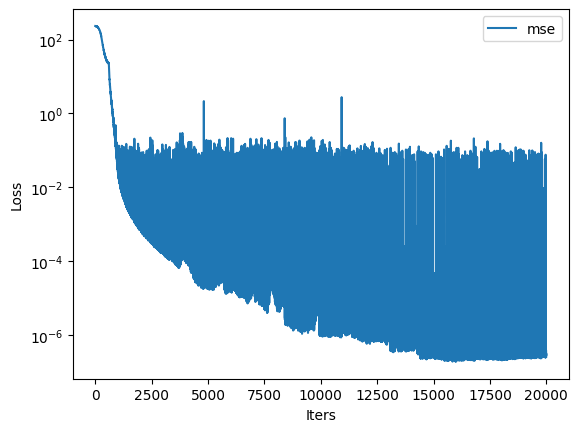

In [8]:
for k,v in losses.items():
    if k=="mse":
        plt.plot(v,label=k)
        print("loss ", k, " min: ", np.min(v), " at ", np.argmin(v))
plt.xlabel('Iters')
plt.yscale("log")
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
lastIter = 16000
weightPath = f'./../../code/models/{cID_prev}/m_{lastIter}.pt'
print(f'Starting from an earlier training',lastIter)

model.load_state_dict(torch.load(weightPath,map_location=device))

Starting from an earlier training 16000


<All keys matched successfully>

## Now evaluate the model!

copy paste from our Common Evaluation Framework 

In [10]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [11]:
import scclevr

In [12]:
from train import hungarian_matching
import torch.nn.functional as F

In [13]:
class TestDataset(Dataset):
    def __init__(self, size = 5000, random_seed = 15, n_obj=2, feature_type="ring"):
        self.size = size
        self.random_seed = random_seed
        self.n_obj = n_obj
        if feature_type=="ring":
            self.rings = scclevr.RingsBinaryUniform(self.n_obj, random_seed = self.random_seed)
            self.event_images, self.object_images, self.n_objects, self.object_features =  self.rings.gen_events(self.size)
        else:
            raise ValueError("Feature type not known.")
        
    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        
        event_image = self.event_images[idx]
        object_image = self.object_images[idx]
        object_feature = self.object_features[idx]
        
       # event_images, object_images, n_objects, object_features =  self.rings.gen_events(1)
        
        event_image = torch.tensor(event_image, dtype=torch.float32)
        event_image_out = event_image
        object_feature = torch.tensor(object_feature, dtype=torch.float32)
        print(event_image.shape)
        event_image = event_image.permute(2,0,1)
        print(event_image.shape)
        event_image_out = event_image_out.permute(2,0,1)

        return event_image, event_image_out, object_feature
    
        

        

In [14]:
ds = TestDataset()

In [15]:
ds.event_images.shape

(5000, 1, 32, 32)

In [16]:
event_image, event_image_out, object_feature = ds.__getitem__(0)
#print(event_image.shape, event_image_out.shape)

torch.Size([1, 32, 32])
torch.Size([32, 1, 32])


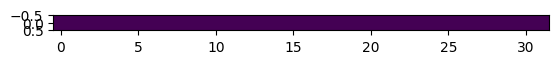

In [17]:
plt.imshow(event_image_out[0])

In [21]:
def _convert_into_pytorch_tensors(event_images, object_images, n_objects, object_features, device):
    return torch.FloatTensor(event_images).to(device), \
               torch.FloatTensor(object_images).to(device), \
               torch.FloatTensor(n_objects).to(device), \
               torch.FloatTensor(object_features).to(device)

In [22]:
with torch.no_grad():
    bs=5000
    N_obj=2
    k_slots=3
    max_n_rings=2
    resolution=(32,32)
    

    rings = scclevr.RingsBinaryUniform(N_obj) # two rings per imagne
    event_images, object_images, n_objects, object_features =  rings.gen_events(bs)
    event_images, object_images, n_objects, object_features =  _convert_into_pytorch_tensors(event_images, object_images, n_objects, object_features, device)
    X = event_images
    mask = object_images
    Y = object_features
    

    #X, mask, _, Y = makeRings(N_img=bs, N_obj=N_obj, device=device)
    queries, att, Y_pred, alpha = model(X)

    # compute reconstruced image X_reco
    att_signal = att * alpha
    new_shape = np.array([att_signal.shape[:-1], resolution]).flatten()
    att_signal = torch.reshape(att_signal, tuple(new_shape))
    X_reco = torch.sum(att_signal, axis=1)[:, None, ::] # why multiply by X???  torch.sum(att_signal*X, axis=1)

    # loss
    l_mse = torch.nn.MSELoss(reduction='none')(X, X_reco).sum(axis=(-1, -2)).mean()
    
    # Reshape the target mask to be flat in the pixels (same shape as att)
    flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))      

    att_ext  = torch.tile(att.unsqueeze(2), dims=(1,1,max_n_rings,1)) 
    mask_ext = torch.tile(flat_mask.unsqueeze(1),dims=(1,k_slots,1,1)) 

    pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)

    # pairwise_cost = comb_loss(att,flat_mask,Y,Y_pred,alpha)
    indices = hungarian_matching(pairwise_cost)

    # Apply the sorting to the predict
    bis=torch.arange(bs).to(device)
    indices=indices.to(device)

    # Loss calc
    slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    l_bce = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean(axis=-1)

    #Y_pred_sorted = torch.cat([Y_pred[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    #Y_true_sorted = torch.cat([Y[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    #l_mse = torch.nn.MSELoss(reduction='none')(Y_pred_sorted,Y_true_sorted).sum(axis=1).mean(axis=-1)

In [29]:
iEvt = 8
slots_sorted[iEvt].reshape(max_n_rings,*resolution).shape

torch.Size([2, 32, 32])

In [30]:
def plot_slots_with_alpha(losses, X, att_signal, Y, cmap = 'Blues', figname=''):
    X = X.detach().cpu()
    Y = Y.detach().cpu()
    att_signal = att_signal.detach().cpu()
    N_obj = Y.shape[0]
    fig, axs = plt.subplots(1,3+N_obj, figsize=(3*(N_obj + 3) ,3))

    # loss
    for k,v in losses.items():
        if (len(v)!=0):
            axs[0].plot(v,label=k)
    axs[0].set_xlabel('Iters')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].set_box_aspect(1)

    # truth
    extent= [-0.5, 0.5]*2

    img = axs[1].imshow(X[0].detach().cpu(), origin='lower', cmap=cmap, extent=extent)
    axs[1].set_title("Truth")
    # colorbar:
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(img, cax=cax, orientation='vertical')

    # rings
    for j in range(1, N_obj+3):
        axs[j].scatter(Y[:, 0], Y[:, 1], marker="x", c='r')
        for yi in Y.cpu().numpy():
            circle = Circle(yi[:2],yi[2],fill=False,color='r')
            axs[j].add_patch(circle)
        axs[j].set_ylim(extent[0], extent[1])
        axs[j].set_xlim(extent[0], extent[1])

    # reco
    for k, j in enumerate(range(2, 3+N_obj)):
        img = axs[j].imshow(att_signal.numpy()[k],  origin='lower', cmap=cmap, extent=extent)
        axs[j].set_title(r"$\alpha \cdot \mathrm{att}$"+" (slot {})".format(k))
        # colorbar:
        divider = make_axes_locatable(axs[j])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(img, cax=cax, orientation='vertical')

    plt.tight_layout()
    if figname:
        plt.savefig(figname)
    plt.show()
    plt.close()

tensor([[9.9979e-01],
        [9.9995e-01],
        [1.4444e-05]])


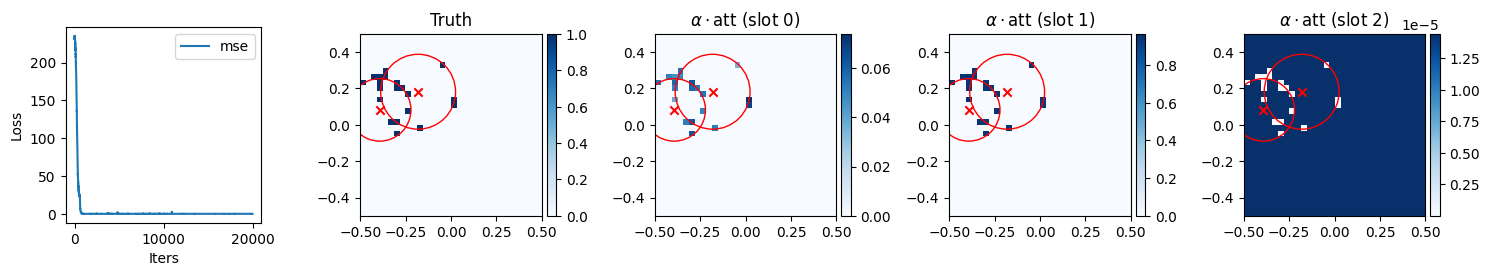

In [31]:
iEvt =8 
print(alpha[iEvt])
plot_slots_with_alpha(losses, X[iEvt], att_signal[iEvt], Y[iEvt])

In [32]:
att_signal.shape

torch.Size([5000, 3, 32, 32])

In [33]:
def plot_slots_2(losses, X, slots, Y, cmap = 'Blues', figname=''):
    #X = X.detach().cpu()
    #Y = Y.detach().cpu()
    #att_signal = att_signal.detach().cpu()
    N_obj = Y.shape[0]
    fig, axs = plt.subplots(1,2+N_obj, figsize=(3*(N_obj + 3) ,3))

    # loss
    for k,v in losses.items():
        if (len(v)!=0):
            axs[0].plot(v,label=k)
    axs[0].set_xlabel('Iters')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].set_box_aspect(1)

    # truth
    extent= [-0.5, 0.5]*2

    img = axs[1].imshow(X[0].detach().cpu(), origin='lower', cmap=cmap, extent=extent)
    axs[1].set_title("Truth")
    # colorbar:
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(img, cax=cax, orientation='vertical')

    # rings
    for j in range(1, N_obj+2):
        axs[j].scatter(Y[:, 0], Y[:, 1], marker="x", c='r')
        for yi in Y.cpu().numpy():
            circle = Circle(yi[:2],yi[2],fill=False,color='r')
            axs[j].add_patch(circle)
        axs[j].set_ylim(extent[0], extent[1])
        axs[j].set_xlim(extent[0], extent[1])

    # reco
    for k, j in enumerate(range(2, 2+N_obj)):
        print(k)
        print(slots.shape)
        img = axs[j].imshow(slots[k],  origin='lower', cmap=cmap, extent=extent)
        axs[j].set_title(r"$\alpha \cdot \mathrm{att}$"+" (slot {})".format(k))
        # colorbar:
        divider = make_axes_locatable(axs[j])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(img, cax=cax, orientation='vertical')

    plt.tight_layout()
    if figname:
        plt.savefig(figname)
    plt.show()
    plt.close()

0
torch.Size([2, 32, 32])
1
torch.Size([2, 32, 32])


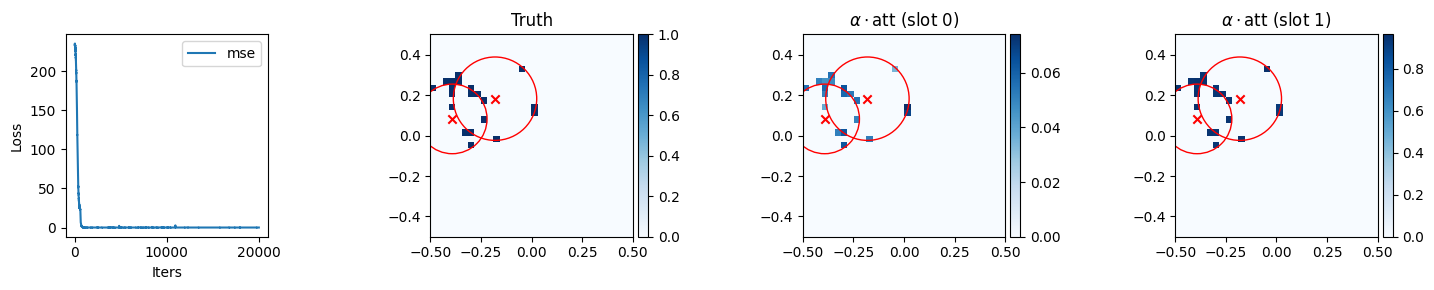

In [34]:
plot_slots_2(losses, X[iEvt], slots_sorted[iEvt].reshape(max_n_rings,*resolution), Y[iEvt])

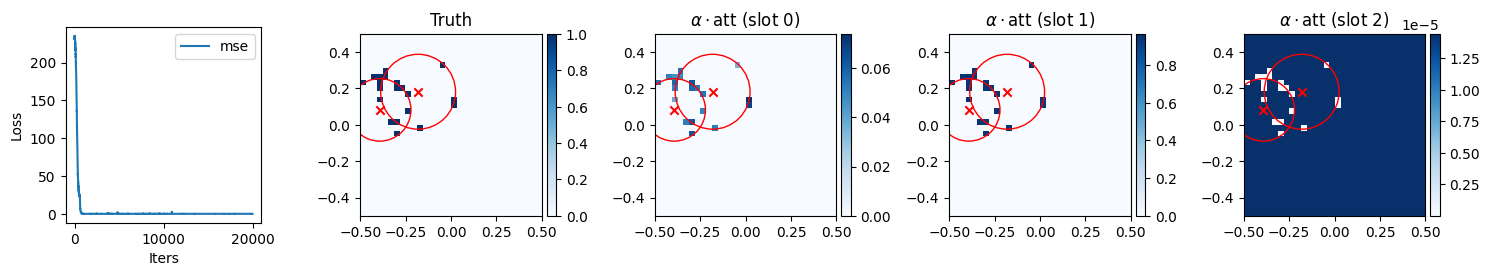

In [35]:
plot_slots_with_alpha(losses, X[iEvt], att_signal[iEvt], Y[iEvt])

Look at a couple examples:

tensor([[9.9984e-01],
        [1.5509e-05],
        [9.9996e-01]])


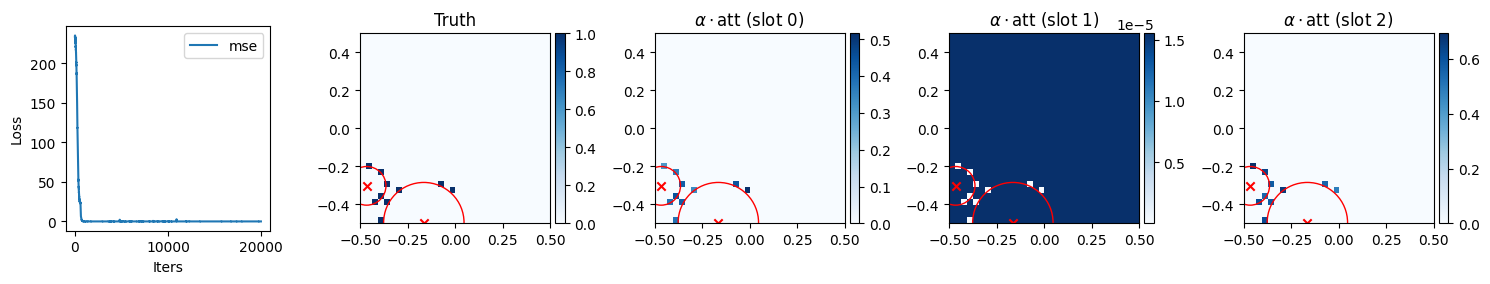

tensor([[9.9996e-01],
        [7.4850e-06],
        [9.9994e-01]])


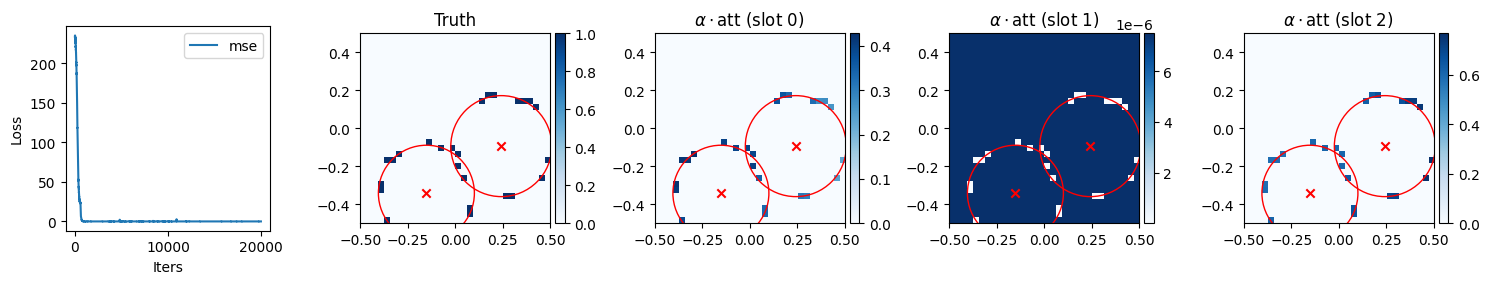

tensor([[9.9995e-01],
        [7.7365e-06],
        [9.9996e-01]])


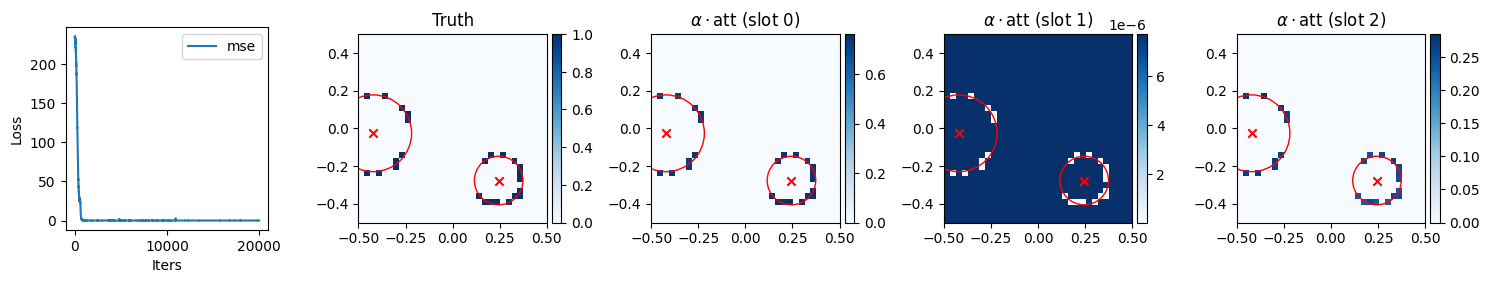

tensor([[6.5347e-06],
        [9.9994e-01],
        [9.9995e-01]])


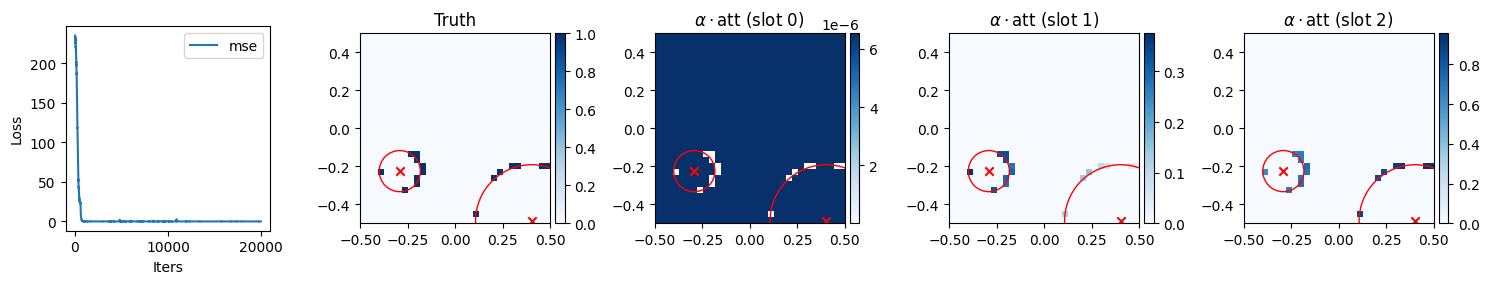

tensor([[9.9990e-01],
        [4.1716e-06],
        [9.9996e-01]])


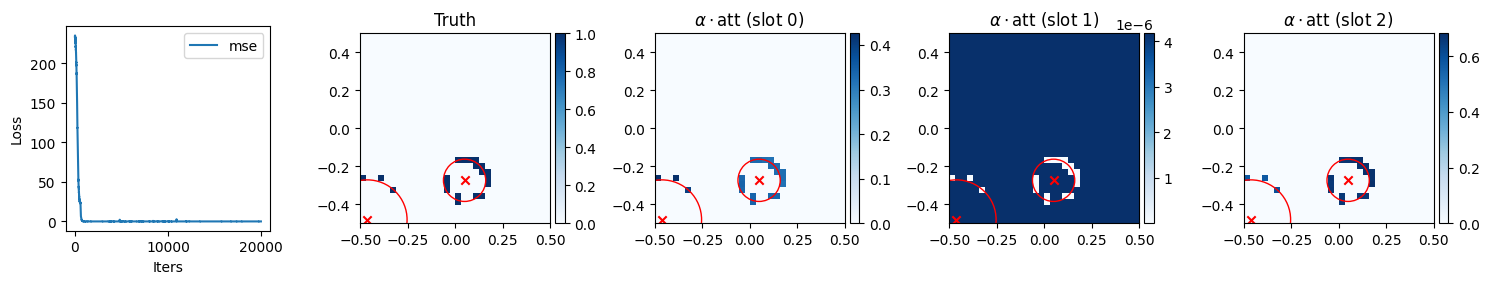

tensor([[5.0224e-06],
        [9.9986e-01],
        [9.9996e-01]])


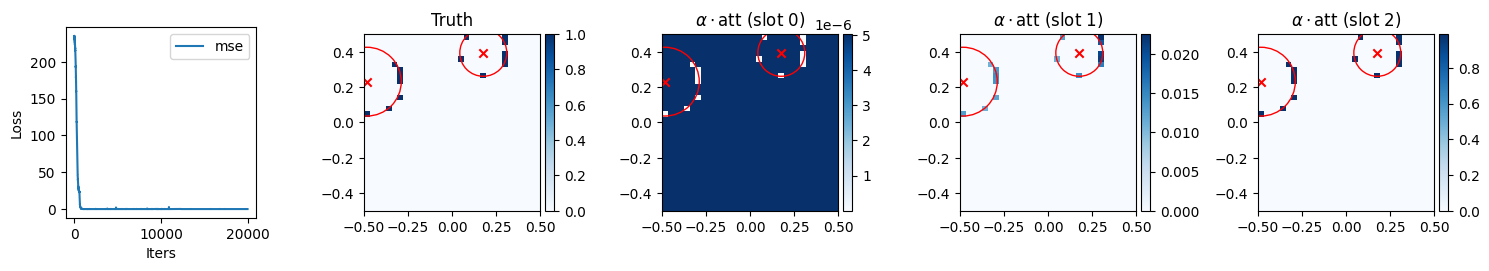

tensor([[9.9995e-01],
        [1.6360e-05],
        [2.1765e-05]])


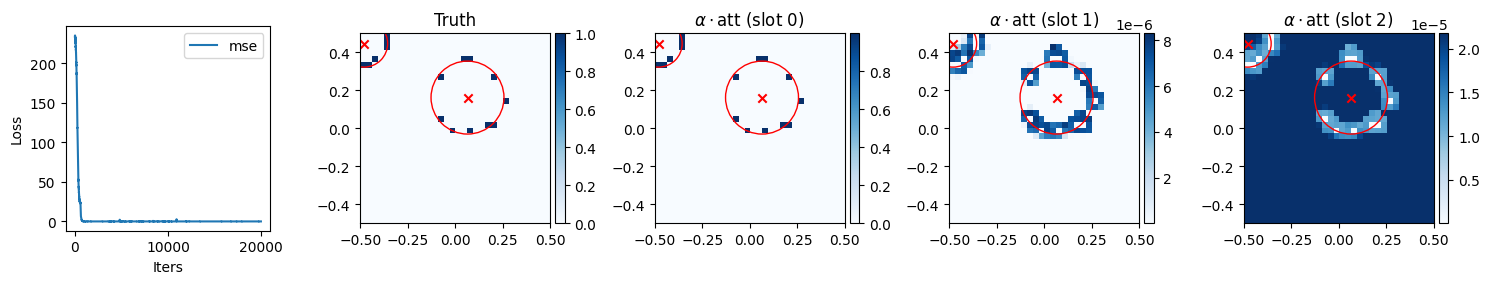

tensor([[9.0421e-06],
        [9.9992e-01],
        [9.9995e-01]])


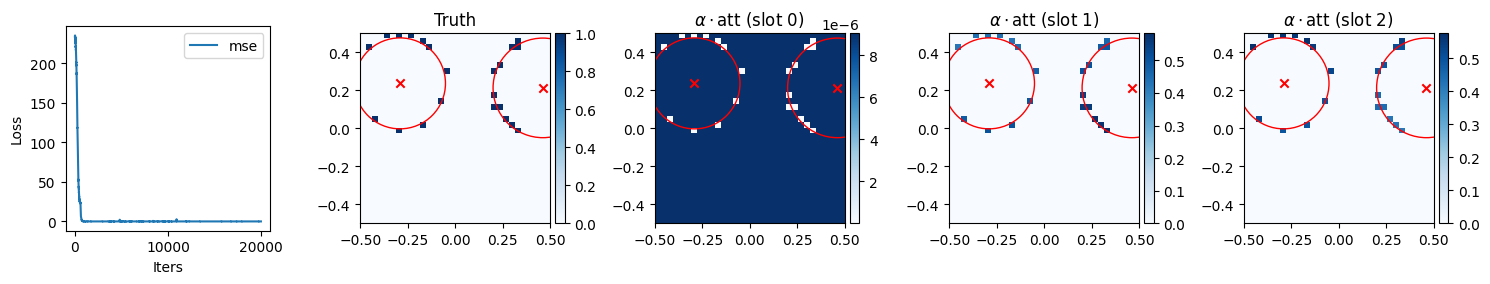

tensor([[9.9979e-01],
        [9.9995e-01],
        [1.4444e-05]])


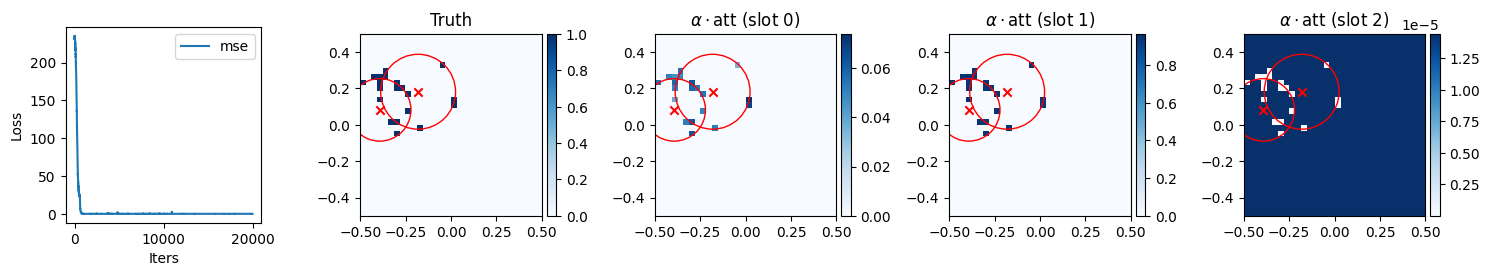

tensor([[7.4710e-06],
        [9.9997e-01],
        [9.9992e-01]])


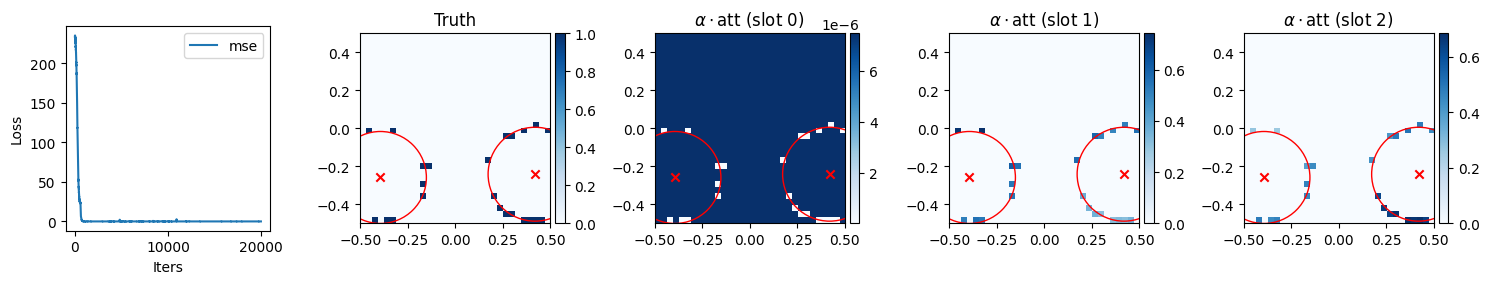

tensor([[9.9992e-01],
        [9.9979e-01],
        [6.8099e-06]])


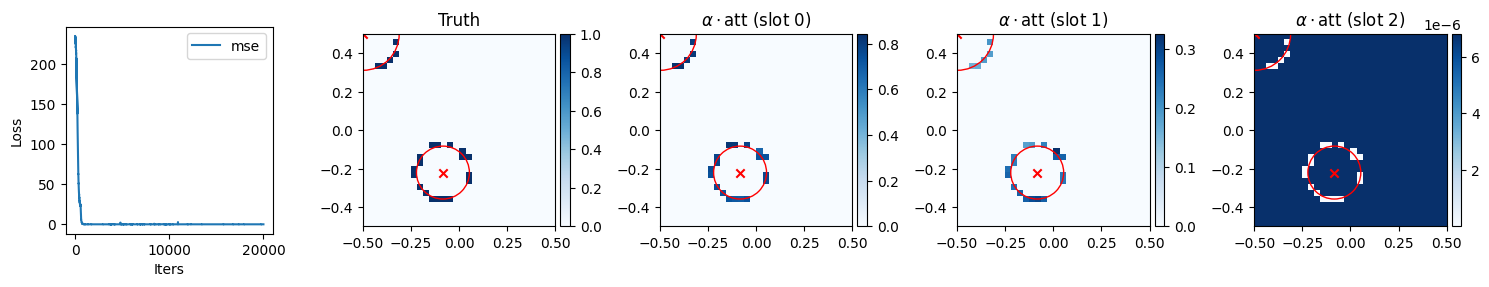

tensor([[9.9997e-01],
        [9.9997e-01],
        [9.0720e-06]])


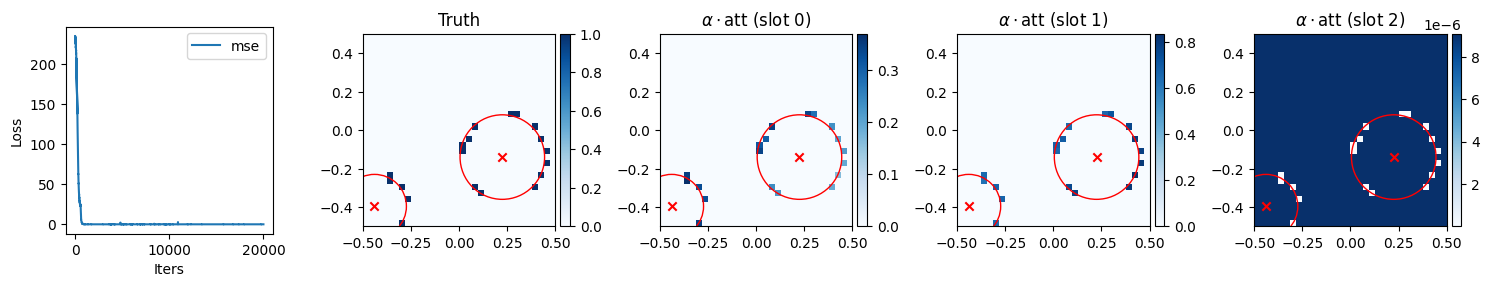

tensor([[9.9993e-01],
        [1.8426e-05],
        [9.9965e-01]])


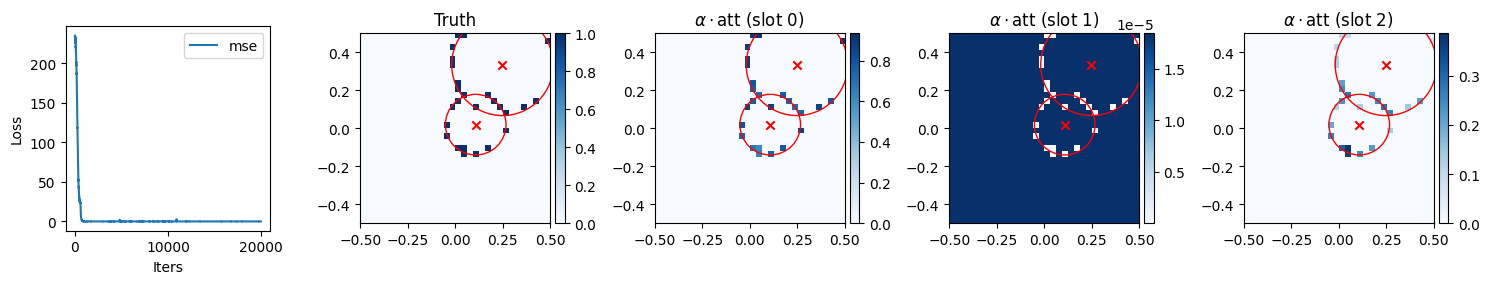

tensor([[2.3038e-06],
        [9.9997e-01],
        [9.9995e-01]])


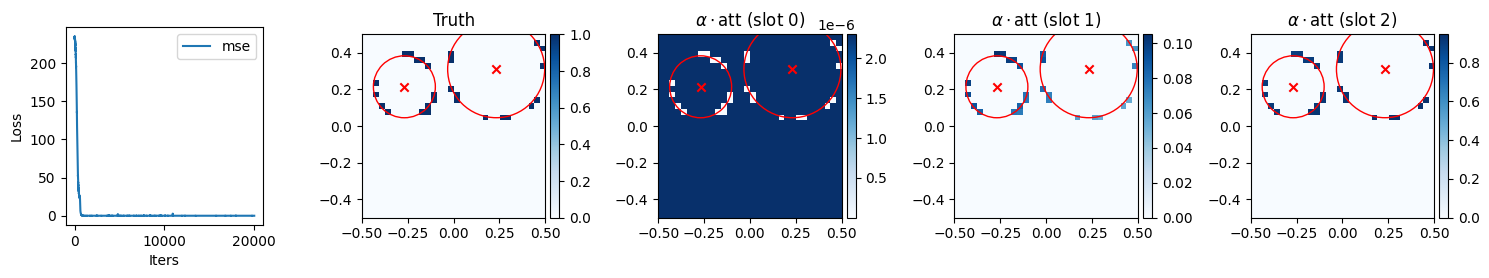

tensor([[1.0964e-05],
        [9.9995e-01],
        [9.9995e-01]])


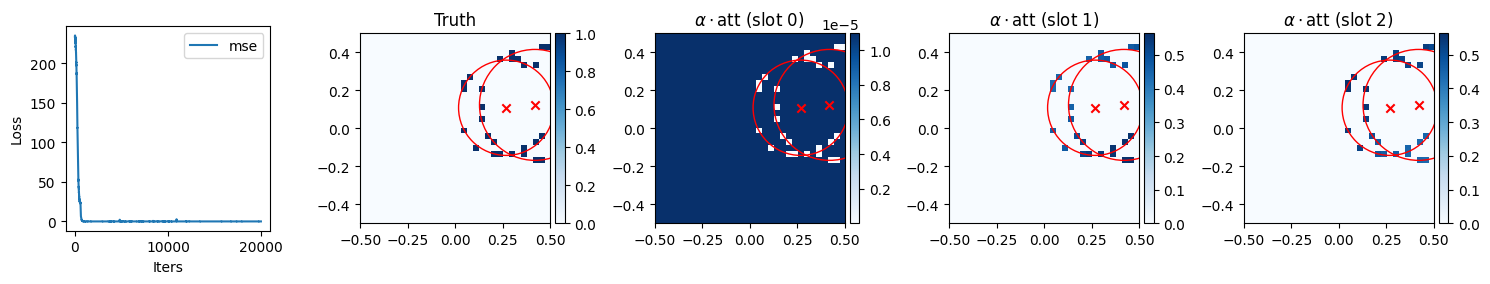

tensor([[9.9996e-01],
        [8.1084e-06],
        [9.9993e-01]])


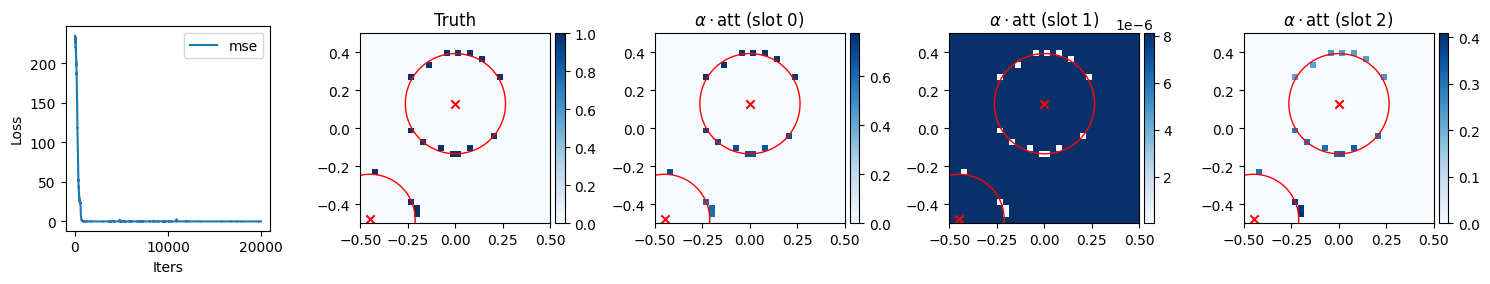

tensor([[9.9982e-01],
        [7.2137e-06],
        [9.9996e-01]])


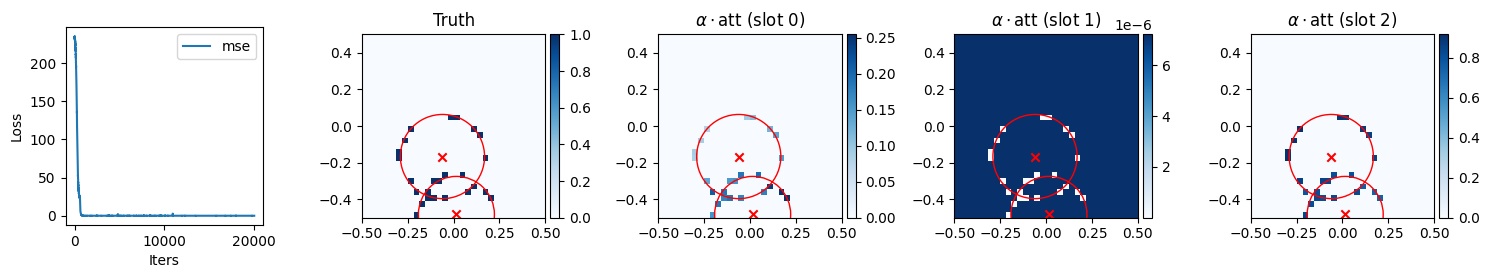

tensor([[5.2001e-06],
        [9.9996e-01],
        [9.9996e-01]])


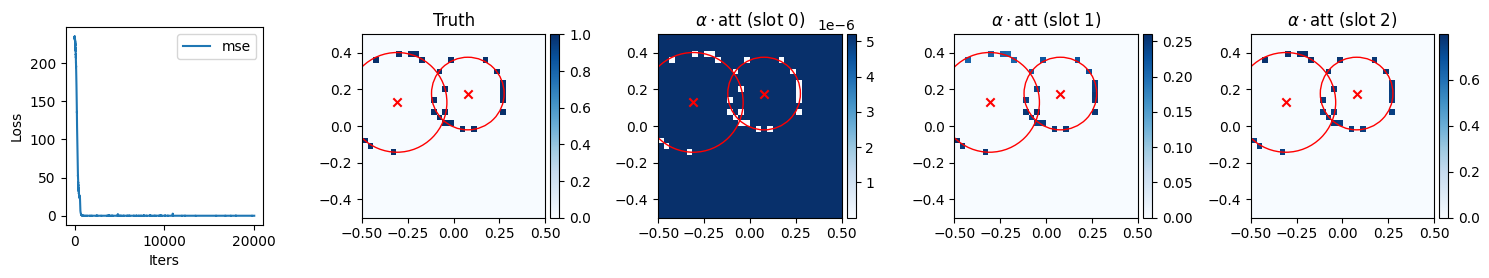

tensor([[7.7970e-06],
        [9.9994e-01],
        [9.9997e-01]])


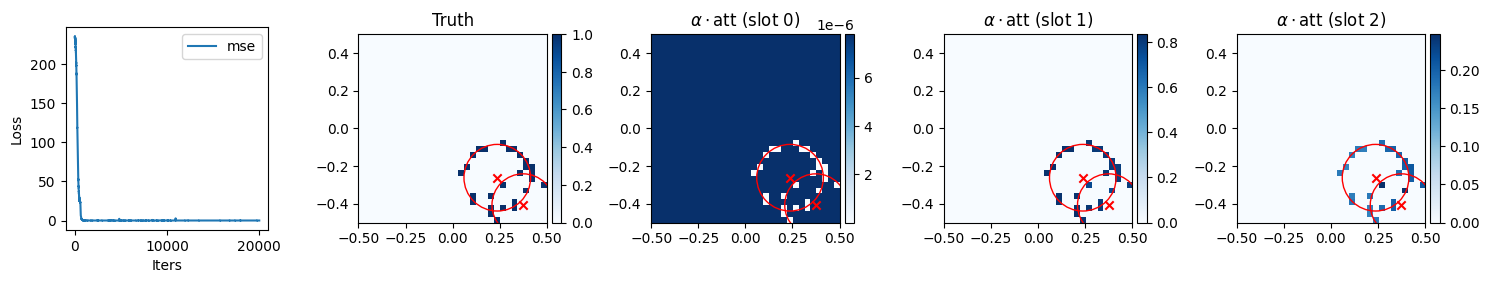

tensor([[8.7030e-06],
        [9.9997e-01],
        [9.9994e-01]])


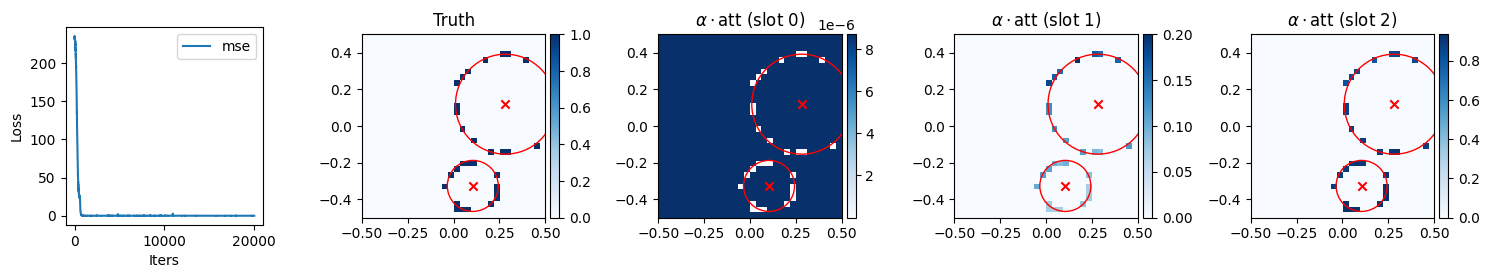

In [36]:
for iEvt in range(20):
    print(alpha[iEvt])
    plot_slots_with_alpha(losses, X[iEvt], att_signal[iEvt], Y[iEvt])

# Make a plan

- write hungarian matching function
- write loss functions

Question: "What shapes should functions have"???

In [37]:
X.shape

torch.Size([5000, 1, 32, 32])

In [38]:
mask.shape

torch.Size([5000, 2, 32, 32])

In [39]:
Y.shape

torch.Size([5000, 2, 3])

In [40]:
ds.event_images.shape

(5000, 1, 32, 32)

In [41]:
ds.object_images.shape

(5000, 2, 32, 32)

In [125]:
class Model_performace:
    def __init__(self, dataset, predictions):
        """
        dataset: Dataset object
        predictions: each feature in a separate picture. Shape: (dataset.size, dataset.n_obj, 32, 32) with (32, 32) being the resolution of the picture.
        """
        self.resolution = dataset.event_images.shape[-2:]
        self.n_obj = dataset.n_obj
        self.size = dataset.size
        self.sorted = False

        # data
        #self.X = dataset.event_images
        self.mask = torch.Tensor(dataset.object_images)
        #self.y = dataset.object_features
        
        # prediction
        self.mask_pred = predictions #(bs, x, 32, 32)
        self.n_pred_img = predictions.shape[1] # =x ; e.g. slot attention 3
        
        # loss
        self.loss_BCE = None
        self.loss_KL = None
        self.loss_MSE = None
    
    def hungarian_matching(self):
        """
        Matches mask to mask_pred as best combination
        """
        if self.sorted==False:
            # Reshape the target mask to be flat in the pixels 
            flat_mask = self.mask.reshape(-1,self.n_obj, np.prod(self.resolution)) # (bs, 2, 1024)
            flat_mask_pred = self.mask_pred.reshape(self.size, self.n_pred_img, np.prod(self.resolution))

            mask_pred_ext  = torch.tile(flat_mask_pred.unsqueeze(2), dims=(1,1,self.n_obj,1)) # (bs, n_pred_img, n_obj, 1024)
            mask_ext = torch.tile(flat_mask.unsqueeze(1),dims=(1,self.n_pred_img,1,1)) # (bs, n_pred_img, n_obj, 1024)

            pairwise_cost = F.binary_cross_entropy(mask_pred_ext, mask_ext,reduction='none').mean(axis=-1)

            indices = hungarian_matching(pairwise_cost)
            bis = torch.arange(self.size)

            # Sort objects!
            mask_pred_sorted = torch.cat([flat_mask_pred[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(self.n_obj)],dim=1)
            mask_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(self.n_obj)],dim=1)

            # save sorted masks
            self.mask_pred = mask_pred_sorted
            self.mask = mask_sorted
            self.sorted = True
        else:
            print("Objects are already sorted")
            
    def loss_BCE(self)
        if sorted==True:
            #self.loss_BCE = F.binary_cross_entropy(self.mask,self.mask_pred,reduction='none').sum(axis=1).mean(axis=-1)
            pass # double check
        else:
            raise ValueError("Must sort objects first. Try 'Model_performance.hunagrian_matching()' and repeat.")
    
    def loss_MSE(self)
        if sorted==True:
            #self.loss_BCE = F.binary_cross_entropy(self.mask,self.mask_pred,reduction='none').sum(axis=1).mean(axis=-1)
            pass # adjust code!!
        else:
            raise ValueError("Must sort objects first. Try 'Model_performance.hunagrian_matching()' and repeat.")
            
    def loss_KL(self)
        if sorted==True:
            #self.loss_BCE = F.binary_cross_entropy(self.mask,self.mask_pred,reduction='none').sum(axis=1).mean(axis=-1)
            pass # adjust code!!
        else:
            raise ValueError("Must sort objects first. Try 'Model_performance.hunagrian_matching()' and repeat.")

    
        

In [126]:
pf = Model_performace(ds, att.reshape(bs, 3, resolution[-1], resolution[-2]))
pf.hungarian_matching()

torch.Size([5000, 2, 1024])
torch.Size([5000, 2, 1024])


# Analyse alphas

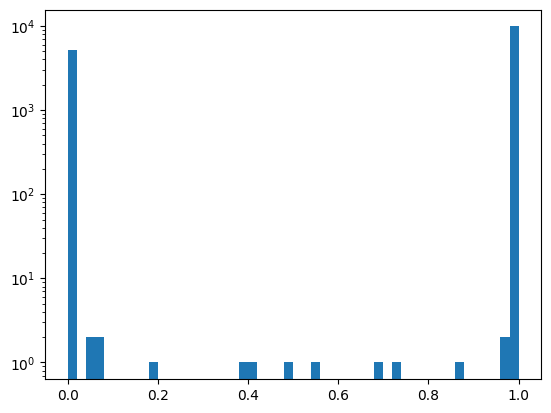

In [81]:
plt.hist(alpha.reshape(15000), bins=50)
plt.yscale("log")
plt.show()

In [181]:
import numpy as np

# Sample data
n = 5  # Replace with your actual number of samples
indices = np.random.rand(n, 3)  # Replace with your actual indices
dataset = np.random.rand(n, 3, 1024)  # Replace with your actual dataset

# Define a mask to filter entries where two indices are close to one and one is close to zero
mask = (np.abs(indices - 1) < 0.1).sum(axis=1) == 2  # Adjust the threshold (0.1) as needed

# Apply the mask to the dataset and reshape
filtered_dataset = dataset[mask]
filtered_dataset = filtered_dataset.reshape(-1, 2, 1024) if filtered_dataset.size > 0 else filtered_dataset.reshape(0, 2, 1024)

print(filtered_dataset.shape)


(0, 2, 1024)


In [182]:
filtered_dataset

array([], shape=(0, 2, 1024), dtype=float64)

In [177]:
def find_signal(att, alpha):
    print(att.shape)
    i_min = np.argmin(alpha, axis=1)
    ind = np.tile(np.arange(3), (att.shape[0], 1))
    print(ind.shape)
    i = np.delete(ind, i_min, axis=0)
    print(i.shape)
    
    print(i_min.shape)
    att_new = att[i_min, ::]
    print(att_new.shape)
    

In [178]:
find_signal(att, alpha)

torch.Size([5000, 3, 1024])
(5000, 3)
(4997, 3)
torch.Size([5000, 1])
torch.Size([5000, 1, 3, 1024])


FALIED HAHA.

In [185]:
att_new = att[:, :2, ::]

In [186]:
att_new.shape

torch.Size([5000, 2, 1024])

In [187]:
pf = Model_performace(ds, att_new.reshape(bs, 2, resolution[-1], resolution[-2]))
pf.hungarian_matching()

torch.Size([5000, 2, 1024])
torch.Size([5000, 2, 1024])


# Make Data

In [ ]:
import scclevr

In [ ]:
N_obj = 2
N_img = 100
rings = scclevr.RingsBinaryUniform(N_obj) # two rings per imagne
event_images, object_images, n_objects, object_features =  rings.gen_events(N_img)

In [ ]:
event_images.shape